<a href="https://colab.research.google.com/github/nooraovo/nooraovo.github.io/blob/main/Multi_neuron_exp2_rank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
class TwoLayerNN(nn.Module):
  def __init__(self, m, d): # fix the second layer to be half 1 and half -1
    super().__init__()
    self.fc1_pos = nn.Linear(d, m, bias=False)
    self.fc1_neg = nn.Linear(d, m, bias=False)
    self.fc2_pos = torch.ones([m, 1])
    self.fc2_neg = -1 * torch.ones([m, 1])


  def activation(self, x): # cubic activation
    return x.clamp(min=0)

  def forward(self, x):
    _out_pos = self.activation(self.fc1_pos(x))
    out_pos = torch.matmul(_out_pos, self.fc2_pos)

    _out_neg = self.activation(self.fc1_neg(x))
    out_neg = torch.matmul(_out_neg, self.fc2_neg)

    return out_pos + out_neg

In [3]:
n = 30
D_in = 2
D_out = 1
m = 30
l0_threshold_grad_matrix = 0.0001

def get_data(n, d): # set data to be y * w + noise
  y = torch.cat((torch.ones(n // 2, 1), -torch.ones(n // 2, 1)), dim=0)
  w = torch.zeros(1, d)
  w[0,0] = 0.3

  X = torch.cat((w.repeat(n//2, 1), -w.repeat(n//2, 1)), dim=0)
  X = X + torch.randn(X.shape)/d**0.5

  return X, y

In [4]:
x, y = get_data(n, D_in)
model =  TwoLayerNN(m, D_in)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9, weight_decay=0)
criteria = nn.MSELoss()

In [5]:
def weights_init(m):
  for p in m.parameters():
    nn.init.xavier_uniform_(p, gain=.1)

# def train(epochs, lr):
#   model =  TwoLayerNN(m, D_in)
#   model.apply(weights_init)
#   optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0, weight_decay=0)

#   model.train()
#   res = []
#   for epoch in range(epochs):
#     output = model(x)
#     loss = criteria(output, y)

#     optimizer.zero_grad()
#     loss.backward()

#     optimizer.step()

#     tmp = []
#     flag = 0
#     for p in model.parameters():
#       print(np.linalg.matrix_rank(p.data.numpy()))
#       tmp += np.linalg.matrix_rank(p.data.numpy())
#       break;
#       # tmp += [(p.clone().detach()**2).sum(dim=-1).numpy()]

#     res += [tmp]
#     if epoch % 100 == 0:
#       print (epoch, loss.item())

#   return np.array(res)
def train(epochs, lr):
  train_loss, nets_avg = [], []
  model = TwoLayerNN(m, D_in)
  model.apply(weights_init)
  net, net_avg = copy.deepcopy(model), copy.deepcopy(model)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0, weight_decay=0)
  net.train()

  for epoch in range(epochs):
    output = net(x)
    loss = criteria(output, y)
    if epoch % 100 == 0:
      print (epoch, loss.item())
    train_loss += [loss.item()]
    nets_avg.append(copy.deepcopy(net))

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

  return train_loss, nets_avg

In [6]:
def compute_grad_matrix(net, X):
    optimizer = torch.optim.SGD(net.parameters(), lr=0.0)
    grad_matrix_list = []
    for i in range(X.shape[0]):
        h = net(X[[i]])
        optimizer.zero_grad()
        h.backward()

        grad_total_list = []
        for param in net.parameters():
            grad_total_list.append(param.grad.flatten().data.numpy())
        grad_total = np.concatenate(grad_total_list)
        grad_matrix_list.append(grad_total)

    grad_matrix = np.vstack(grad_matrix_list)
    return grad_matrix

def compute_grad_matrix_ranks(nets, X, l0_threshold_grad_matrix=0.0001):
    n_params = sum([np.prod(param.shape) for param in nets[-1].parameters()])
    X_eval = X[:n_params]
    grad_matrix_ranks = []
    for net in nets:
        svals = np.linalg.svd(compute_grad_matrix(net, X_eval))[1]
        rank = (svals / svals[0] > l0_threshold_grad_matrix).sum()
        grad_matrix_ranks.append(rank)
    return grad_matrix_ranks

In [14]:
lr_small = 0.00005
loss_small, net_small = train(15000, lr=lr_small)

0 1.040345311164856
100 1.0009608268737793
200 0.9662190079689026
300 0.9355652928352356
400 0.9091150760650635
500 0.8859449028968811
600 0.8659864068031311
700 0.8487323522567749
800 0.8332633376121521
900 0.8193012475967407
1000 0.8071600198745728
1100 0.796528697013855
1200 0.7869434952735901
1300 0.7784439921379089
1400 0.7710964679718018
1500 0.7643677592277527
1600 0.7582805752754211
1700 0.7527312636375427
1800 0.7474063038825989
1900 0.7425926923751831
2000 0.7383500337600708
2100 0.7345048785209656
2200 0.7309257388114929
2300 0.7274712324142456
2400 0.7243223786354065
2500 0.7215753197669983
2600 0.719146728515625
2700 0.716978907585144
2800 0.7149377465248108
2900 0.7130550146102905
3000 0.711257815361023
3100 0.7096096277236938
3200 0.7080762982368469
3300 0.7066910266876221
3400 0.705403745174408
3500 0.704191267490387
3600 0.7030691504478455
3700 0.7020428776741028
3800 0.701087236404419
3900 0.7001808285713196
4000 0.6993135809898376
4100 0.6984831690788269
4200 0.69769

In [15]:
lr_large = 0.03
loss_large, net_large = train(15000, lr=lr_large)

0 0.9946977496147156
100 0.6625450849533081
200 0.6528781652450562
300 0.6451956629753113
400 0.6389132738113403
500 0.6336653828620911
600 0.6292798519134521
700 0.62437903881073
800 0.6208186745643616
900 0.6176680326461792
1000 0.6140176653862
1100 0.6112136244773865
1200 0.6086589097976685
1300 0.6062461137771606
1400 0.603923499584198
1500 0.601686418056488
1600 0.5995810031890869
1700 0.5975491404533386
1800 0.5956249833106995
1900 0.5936166048049927
2000 0.59169602394104
2100 0.5897868871688843
2200 0.5880884528160095
2300 0.5864726901054382
2400 0.5849496722221375
2500 0.5835134983062744
2600 0.5821705460548401
2700 0.5808781981468201
2800 0.5796748995780945
2900 0.5785329937934875
3000 0.577449381351471
3100 0.5764532089233398
3200 0.57547926902771
3300 0.5745237469673157
3400 0.5736265778541565
3500 0.5727291703224182
3600 0.5718889236450195
3700 0.5710819363594055
3800 0.5702654123306274
3900 0.5695183873176575
4000 0.5687543749809265
4100 0.5680528879165649
4200 0.567343652

TwoLayerNN(
  (fc1_pos): Linear(in_features=2, out_features=30, bias=False)
  (fc1_neg): Linear(in_features=2, out_features=30, bias=False)
)


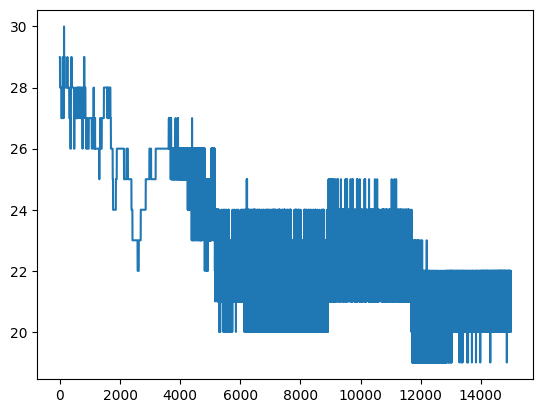

In [16]:
print(net_small[1])
n_params = sum([np.prod(param.shape) for param in net_small[-1].parameters()])
grad_matrix_ranks = compute_grad_matrix_ranks(net_small, x[:n_params], l0_threshold_grad_matrix)
plt.plot(grad_matrix_ranks)
# for i in range(m):
#   plt.xlim(0, 400)
#   plt.ylim(0, 0.15)
#   plt.plot(norm_small[::10, 0, i])
#   plt.title('lr={0}'.format(lr_small))
  #plt.plot(log2[::10, 1, i])

TwoLayerNN(
  (fc1_pos): Linear(in_features=2, out_features=30, bias=False)
  (fc1_neg): Linear(in_features=2, out_features=30, bias=False)
)


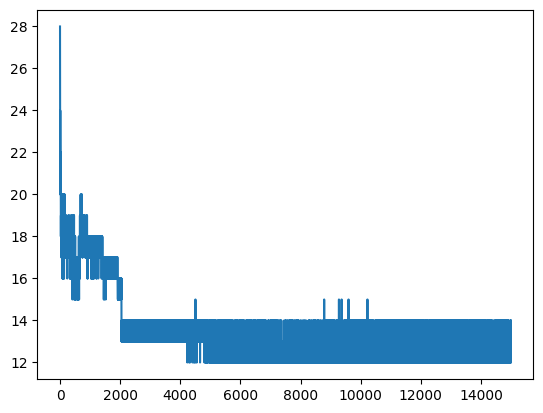

In [17]:
print(net_large[1])
n_params = sum([np.prod(param.shape) for param in net_large[-1].parameters()])
grad_matrix_ranks = compute_grad_matrix_ranks(net_large, x[:n_params], l0_threshold_grad_matrix)
plt.plot(grad_matrix_ranks)

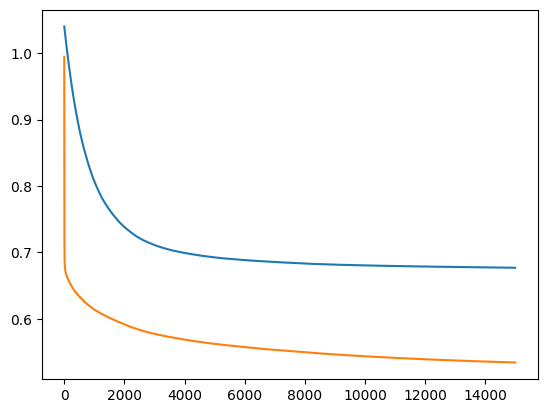

In [18]:
plt.plot(loss_small)
plt.plot(loss_large)